In [1]:
import numpy as np
import re
import os
import tweepy
#import twitter
import csv
import pandas as pd
import operator

In [2]:
consumer_key=''
consumer_secret=''
access_token=''
access_token_secret=''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth,wait_on_rate_limit=True)

# 1. Load the data
load downloaded tweet for the india vs west indies cricket tournament for the period 11/4 to 11/11 2018

In [3]:
df = pd.read_csv("sports_tweet_final.csv",encoding='utf-8')

In [4]:
#add column for the labeling of tweet
# team column will hold team indicator either india or west indies as a label
df['team']=""

In [5]:
#player holds name of the player from the either of the team
df['player']=""

In [6]:
df.head()

,timestamp,tweet,source,team,player
0,11/8/2018 23:48,b'RT @PatelTejesh: Desperately waiting for sem...,Twitter Web Client,,
1,11/8/2018 22:47,b'India-West Indies ODI Series \xe2\x80\x93 3r...,Tweet Old Post,,
2,11/8/2018 22:08,b'@imVkohli \nI think ur immature and Impulsiv...,Twitter for Android,,
3,11/8/2018 21:43,b'STOP SUPPORTING @BCCI TEAM!!! MAKE THEM TO L...,Twitter for Android,,
4,11/8/2018 21:10,b'RT @umeshkshakya: Watching #INDVsWI 2nd T20 ...,Twitter for Android,,


In [7]:
df.describe()

,timestamp,tweet,source,team,player
count,27750,27750,27750,27750,27750
unique,4173,10528,65,1,1
top,11/4/2018 16:49,b'RT @ashwinravi99: Said this in 2011 when I g...,Twitter for Android,,
freq,129,692,17830,27750,27750


###### label the data
* we label the tweet based on team name or player name present
* if team name if present in the tweet then we label that tweet with the team name, we also consider number of time team name came up in the tweet so that we can select team with max count
* player label is calculated in similar way
* playing players dictionery is created to capture the variations in player name
* each tweet is processed to find out if it contains players name and how many times
* player with max count is considered as label for that particular tweet

In [8]:
#players name dictionary 
players = {'Rohit': 'Rohit,imRo45,Rohit Sharma' , 'Shikhar':'SDhawan25,dhawan,Shikhar','Rahul':'KL Rahul,Rahul,klrahul11'
 ,'Dinesh':'DK,Dinesh,Karthik,DineshKarthik', 'Manish':'Manish,Pandey,im_manishpandey','Shreyas':'Shreyas,Iyer', 'Rishabh':'Rishabh,Pant,Rishabhpanth'
 ,'Krunal':'krunal,krunalpandya24' ,'washington':'washington,sundar','bhuveneshwar':'bhuvi,bhuveneshwar','Chahal':'chahal,yuzi,Yuzevendra,yuzi_chahal'
 ,'Kuldeep':'kuldeep,mkuldeep18' , 'Bumrah':'Bumrah,Jaspritbumrah93' , 'Khaleel':'Khaleel,Ahmed','Umesh':'Umesh,y_umesh','Ajinkya':'Rahane,Ajinkya,ajinkyarahane88'
 ,'Dhoni':'msdhoni,dhoni','Virat': 'imVkohli,kohli,virat', 'Hardik':'hardik,hardikpandya7'
 ,'Carlos':'brathwaite88,Carlos','Fabian':'Fabian','Darren':'DMBravo46,Darren','Shimron':'Shetmyer,Shimron'
 ,'Evin':'Evin17Lewis,Evin','Obed':'Obed','Ashley':'AshleyNurse,Ashley','Keemo':'Keemo'
 ,'Khary':'Khary','Kieron':'KieronPollard55,Kieron','Rovman':'Rovman','Denesh':'Denesh','Andre':'Russell12A,Andre','Sherfane':'Sherfane'
 ,'Oshane':'Oshane'}

#clean the tweets

def clean_tweets(tweet):
    url_pattern = re.compile('https\S+')
    url = url_pattern.sub('',tweet)
    mentions = re.compile('#\w+')
    clean_tweet = (mentions.sub('',url))
    clean_tweet = clean_tweet.lower()
    return clean_tweet

#get label based on team name
def get_team_label(tweet):
        if tweet.find('india') != -1 and tweet.find('West Indies') !=1:
                return 2
        elif tweet.find('West Indies') != -1:
                return 0
        elif tweet.find('India') != -1:
                return 1
        else:
                return 3 

#get label based on player name
def get_player_label(tweet):
    for k, v in players.items():    
        names = v.split(',')
        for name in names:
            if tweet.find(name.lower()) != -1:
                return k

#get player name based on player name count
def get_player_label_weight(tweet):
    nameCountDict = {}
    for k, v in players.items():    
        names = v.split(',')
        nameCount = 0
        for name in names:
            nameCount = nameCount + tweet.count(name.lower())
        nameCountDict[k] = nameCount
    #print(nameCountDict)
    #print(max(nameCountDict.values()))
    if max(nameCountDict.values()) != 0:
        return max(nameCountDict.items(), key=operator.itemgetter(1))[0]
    else:
        return -1
            
#team name based on team name count, 1 for india, 0 for west indies otherwise 2               
def get_team_label_weight(tweet):
        indCount = tweet.count("india")
        westIndCount = tweet.count("west indies")
        #print("india,westind", indCount, westIndCount)
        if indCount > westIndCount:
            return 1
        elif westIndCount > indCount:
            return 0
        else:
            return 2
        

In [9]:
get_player_label_weight("b'rt @pateltejesh: desperately waiting for semi final  t20worldcup'")

-1

In [10]:
#clean tweets and add labels
for i,row in df.iterrows():
    clean_tweet = clean_tweets(row['tweet'])
    df.at[i,'tweet'] = clean_tweet
    team_label = get_team_label_weight(clean_tweet)
    df.at[i,'team'] = team_label
    player_label = get_player_label_weight(clean_tweet)
    df.at[i,'player'] = player_label

In [11]:
df['team'].value_counts()

2    20869
1     6319
0      562
Name: team, dtype: int64

In [12]:
df['player'].value_counts()

-1              13402
Rohit            3301
Krunal           1721
Dinesh           1649
Dhoni            1397
Virat            1237
Kuldeep           814
Shikhar           606
Khaleel           563
Rahul             554
Rishabh           452
Oshane            299
Manish            284
Bumrah            237
Umesh             205
Andre             174
Kieron            148
Carlos            134
Chahal            108
Hardik             82
Darren             73
bhuveneshwar       56
Fabian             51
Shreyas            43
washington         42
Denesh             33
Shimron            25
Keemo              19
Rovman             10
Evin                9
Khary               9
Ajinkya             7
Ashley              5
Sherfane            1
Name: player, dtype: int64

# 2.Start ML process
We want to predict team and player class based on the tweets


Model will be trained to classify team and player


Prepare datafram for ML

In [13]:
ml_df = df.copy()

In [14]:
#assign numbers for players
players_class = {'Rohit': '1' , 'Shikhar':'2','Rahul':'3'
 ,'Dinesh':'4', 'Manish':'5','Shreyas':'6', 'Rishabh':'7'
 ,'Krunal':'8' ,'washington':'9','bhuveneshwar':'10','Chahal':'11'
 ,'Kuldeep':'12' , 'Bumrah':'13' , 'Khaleel':'14','Umesh':'15','Ajinkya':'16'
 ,'Dhoni':'17','Virat': '18', 'Hardik':'19'
 ,'Carlos':'20','Fabian':'21','Darren':'22','Shimron':'23'
 ,'Evin':'24','Obed':'25','Ashley':'26','Keemo':'27'
 ,'Khary':'28','Kieron':'29','Rovman':'30','Denesh':'31','Andre':'32','Sherfane':'33'
 ,'Oshane':'34'}

ind_players = ['Rohit', 'Shikhar','Rahul'
 ,'Dinesh', 'Manish','Shreyas', 'Rishabh'
 ,'Krunal' ,'washington','bhuveneshwar','Chahal'
 ,'Kuldeep', 'Bumrah' , 'Khaleel','Umesh','Ajinkya'
 ,'Dhoni','Virat', 'Hardik','Denesh']

wi_players = ['Carlos','Fabian','Darren','Shimron'
 ,'Evin','Obed','Ashley','Keemo'
 ,'Khary','Kieron','Rovman','Andre','Sherfane'
 ,'Oshane']


In [15]:
#add class column
ml_df["player_class"] = ""

In [16]:
ml_df.head()

,timestamp,tweet,source,team,player,player_class
0,11/8/2018 23:48,b'rt @pateltejesh: desperately waiting for sem...,Twitter Web Client,2,-1,
1,11/8/2018 22:47,b'india-west indies odi series \xe2\x80\x93 3r...,Tweet Old Post,1,-1,
2,11/8/2018 22:08,b'@imvkohli \ni think ur immature and impulsiv...,Twitter for Android,2,Virat,
3,11/8/2018 21:43,b'stop supporting @bcci team!!! make them to l...,Twitter for Android,2,Virat,
4,11/8/2018 21:10,b'rt @umeshkshakya: watching 2nd t20 cricket ...,Twitter for Android,2,Umesh,


In [17]:
#we can improve team classification by assigning teams player tweet to the team
# add classification number for players
for i,row in ml_df.iterrows():
    if row['player'] != -1:
        ml_df.at[i,'player_class'] = players_class.get(row['player'])
    
    if row['team'] == 2 and row['player'] != -1:
        if row['player'] in ind_players:
            ml_df.at[i,'team'] = 1
        elif row['player'] in wi_players:
            ml_df.at[i,'team'] = 0


In [18]:
ml_df.head()

,timestamp,tweet,source,team,player,player_class
0,11/8/2018 23:48,b'rt @pateltejesh: desperately waiting for sem...,Twitter Web Client,2,-1,
1,11/8/2018 22:47,b'india-west indies odi series \xe2\x80\x93 3r...,Tweet Old Post,1,-1,
2,11/8/2018 22:08,b'@imvkohli \ni think ur immature and impulsiv...,Twitter for Android,1,Virat,18
3,11/8/2018 21:43,b'stop supporting @bcci team!!! make them to l...,Twitter for Android,1,Virat,18
4,11/8/2018 21:10,b'rt @umeshkshakya: watching 2nd t20 cricket ...,Twitter for Android,1,Umesh,15


In [19]:
ml_df['team'].value_counts()

1    16109
2    10481
0     1160
Name: team, dtype: int64

In [20]:
ml_df.to_csv('ml_df.csv')

## 2.1 Process for team classification
* create train and test data
* train dataset would be before final which is 11/4 to 11/10
* final day data would be used for test

In [21]:
#create df for team with valid labels
# drop team label 2 which is no classification for the team
ml_df_team = ml_df.drop(ml_df[ml_df.team == 2].index)
ml_df_team['team'].value_counts()

1    16109
0     1160
Name: team, dtype: int64

In [22]:
ml_df_team.shape

(17269, 6)

In [23]:
#create training dataset
ml_df_team['timestamp'] = pd.to_datetime(ml_df_team['timestamp'])
start_date = '11-04-2018'
end_date = '11-10-2018'
mask = (ml_df_team['timestamp'] > start_date) & (ml_df_team['timestamp'] <= end_date)
ml_df_team_train = ml_df_team.loc[mask]
ml_df_team_train.shape

(14541, 6)

In [24]:
#create test data set
start_date = '11-11-2018'
end_date = '11-12-2018'
mask = (ml_df_team['timestamp'] > start_date) & (ml_df_team['timestamp'] <= end_date)
ml_df_team_test = ml_df_team.loc[mask]
ml_df_team_test.shape

(1298, 6)

In [25]:
# create target variable
y = ml_df_team_train["team"]
y=y.astype('int')
y.shape

(14541,)

In [26]:
# create input/X variable using vectorizer
from sklearn.feature_extraction.text import CountVectorizer
cvect = CountVectorizer(lowercase=True, stop_words="english", max_df=0.98, min_df=0.02)

In [27]:
X = cvect.fit_transform(ml_df_team_train['tweet'])
X.shape

(14541, 109)

In [28]:
#split dataset for training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(11632, 109)
(2909, 109)


In [29]:
#train logistic regression model
#model with default parameters
lr_team = LogisticRegression() 

In [30]:
cv_scores = cross_val_score(lr_team, X_train, y_train, scoring="accuracy", cv=10)
print(cv_scores)


[0.98883162 0.98367698 0.98539519 0.99398625 0.98539519 0.98109966
 0.98881239 0.98623064 0.98364888 0.98364888]


In [31]:
print(np.mean(cv_scores))

0.9860725671463466


* acuracy on taring data is 98%

In [32]:
#fit the model
lr_team.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
#predict on test and calculate the accuracy
from sklearn.metrics import accuracy_score

preds_test = lr_team.predict(X_test)
print("Test accuracy:", np.round(accuracy_score(y_test, preds_test), 3))

Test accuracy: 0.989


* **accuracy on the split test set 98.9%**

predict on the final days data to understand the winner

convert tweets to the input format

In [34]:

X_final_day = cvect.transform(ml_df_team_test['tweet'])
X_final_day.shape

(1298, 109)

In [35]:
# predict using model
preds_final_day = lr_team.predict(X_final_day)

In [36]:
#convert numbers to team names
preds_final_day_team_names = []
for i in np.nditer(preds_final_day):
    if i == 1:
        preds_final_day_team_names.append("India")
    else:
         preds_final_day_team_names.append("West Indies")    

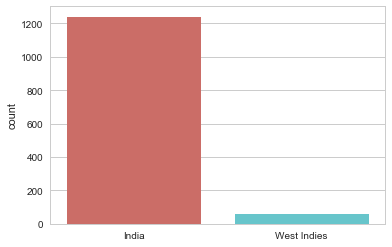

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

sns.countplot(x=preds_final_day_team_names, palette='hls')
plt.show()

In [38]:
ind_count = np.count_nonzero(preds_final_day == 1)
wi_count = np.count_nonzero(preds_final_day == 0)
india_pred_pct = ind_count/(ind_count+wi_count)
print("Percentage of team India win prediction is", india_pred_pct*100)
wi_pred_pct = wi_count/(ind_count+wi_count)
print("Percentage of team West India win prediction is", wi_pred_pct*100)

Percentage of team India win prediction is 95.53158705701078
Percentage of team West India win prediction is 4.468412942989214


* **Based on tweets our model predicted 95% tweets for team India and 4% team West Indies**
* **As per the actual results team India won final T20 match on 11/11 which means team India would be most talked about team on that day**

## 2.2 Player Classification
Final Day tweet classification for the players

In [39]:
#create df for players with valid labels
# drop player label -1 which is no classification for the palyer
ml_df_player = ml_df.drop(ml_df[ml_df.player == -1].index)
ml_df_player['player'].value_counts()

Rohit           3301
Krunal          1721
Dinesh          1649
Dhoni           1397
Virat           1237
Kuldeep          814
Shikhar          606
Khaleel          563
Rahul            554
Rishabh          452
Oshane           299
Manish           284
Bumrah           237
Umesh            205
Andre            174
Kieron           148
Carlos           134
Chahal           108
Hardik            82
Darren            73
bhuveneshwar      56
Fabian            51
Shreyas           43
washington        42
Denesh            33
Shimron           25
Keemo             19
Rovman            10
Evin               9
Khary              9
Ajinkya            7
Ashley             5
Sherfane           1
Name: player, dtype: int64

In [40]:
ml_df_player.shape

(14348, 6)

In [41]:
# create train and test data
# train dataset would be before final which is 11/4 to 11/10
# final day data would be used for test

#create training dataset
ml_df_player['timestamp'] = pd.to_datetime(ml_df_team['timestamp'])
start_date = '11-04-2018'
end_date = '11-10-2018'
mask = (ml_df_player['timestamp'] > start_date) & (ml_df_player['timestamp'] <= end_date)
ml_df_player_train = ml_df_player.loc[mask]
ml_df_player_train.shape

(12435, 6)

In [42]:
#create test data set
start_date = '11-11-2018'
end_date = '11-12-2018'
mask = (ml_df_player['timestamp'] > start_date) & (ml_df_player['timestamp'] <= end_date)
ml_df_player_test = ml_df_player.loc[mask]
ml_df_player_test.shape

(1008, 6)

In [43]:
#target variable
y_p = ml_df_player_train["player_class"]
y_p=y_p.astype('int')
y_p.shape

(12435,)

In [44]:
# create input/X variable using vectorizer
from sklearn.feature_extraction.text import CountVectorizer
cvect_p = CountVectorizer(lowercase=True, stop_words="english", max_df=0.98, min_df=0.02)

In [45]:
X_p = cvect_p.fit_transform(ml_df_player_train['tweet'])
X_p.shape

(12435, 117)

In [46]:
#split dataset for training
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X_p, y_p, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(9948, 117)
(2487, 117)


In [47]:
#train logistic regression model
#multinomial model as multi class classification
lr_player = LogisticRegression(multi_class="multinomial", solver="lbfgs") 

In [48]:
cv_scores = cross_val_score(lr_player, X_train, y_train, scoring="accuracy", cv=10)
print(cv_scores)

C:\Users\iw267\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


[0.91699605 0.93445879 0.93731343 0.936      0.92592593 0.93951613
 0.93023256 0.93597561 0.95107034 0.93564862]


In [49]:
print(np.mean(cv_scores))

0.9343137449034421


* acuracy on taring data is 93%

In [50]:
#fit the model
lr_player.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [51]:
#predict on test and calculate the accuracy
from sklearn.metrics import accuracy_score

preds_test = lr_player.predict(X_test)
print("Test accuracy:", np.round(accuracy_score(y_test, preds_test), 3))

Test accuracy: 0.93


* acuracy on test data is 93%

In [52]:
# predict on the final days data to understand the player classification
#convert tweets to the input format
X_final_day = cvect_p.transform(ml_df_player_test['tweet'])
X_final_day.shape

(1008, 117)

In [53]:
# predict using model
preds_final_day_player = lr_player.predict(X_final_day)

In [54]:
#convert numbers to player names
preds_final_day_player_names = []
for i in np.nditer(preds_final_day_player):
    for key, value in players_class.items():        
        #lKey = [key for key, value in players_class.items() if value == i][0]
        #print(key)
        if int(value) == i:
            #print(key)
            preds_final_day_player_names.append(key)
            break;

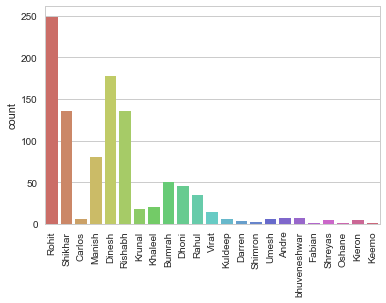

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

sns.countplot(x=preds_final_day_player_names, palette='hls')
plt.xticks(rotation=90)
plt.show()
#players_class

* **Rohit mentioned most of the time. He was the India teams captain and best batsman for the tournament**
* **Players from WI mentioned very less time comapred to the Indian players**

# 3 Network
Network detection - finding players inetraction graph from the tweets
* generate network

In [56]:
import networkx as nx

In [57]:
import re
import itertools
#regx to find account name form the tweet
regx = re.compile('@\w+')

edges = []

#create edges for the twitter handle present in the tweet
# if more than one tweet handle is present in the tweet then it means they are related or had some inetraction 
for i,row in ml_df_player.iterrows():
    users = regx.findall(row["tweet"])
    if len(users) > 1:
        edges.extend((list(itertools.combinations(users, 2))))

len(edges)

8062

In [58]:
G = nx.DiGraph()
G.add_edges_from(edges)
G.number_of_nodes()

439

In [59]:
G.number_of_edges()

1146

###### Visualize network

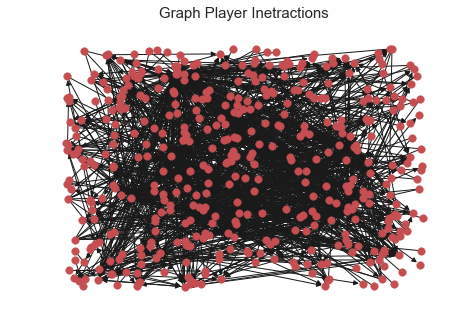

<Figure size 1440x1440 with 0 Axes>

In [60]:
%matplotlib inline
import matplotlib.pyplot as plt
#nx.draw(G)
nx.draw_random(G, with_labels=False, node_size=60,font_size=8)
plt.title('Graph Player Inetractions', size=15)
plt.figure(3,figsize=(20,20))
#nx.draw_networkx(G, edge_color="blue")

plt.show()

In [61]:
#create edge file to analyze in gephi
import xlsxwriter
#function to write edge relationship 
def writeEdgeFileFromList(x, output_filepath):
    workbook = xlsxwriter.Workbook(output_filepath)
    worksheet = workbook.add_worksheet()
    for i,e in enumerate(x):
        worksheet.write(i,0,e[0])
        worksheet.write(i,1,e[1])
        
    workbook.close()

In [62]:
edges.insert(0, list(["Source","Target"]))
writeEdgeFileFromList(edges,"edges.xlsx")

###### Import graph generated from Gephi

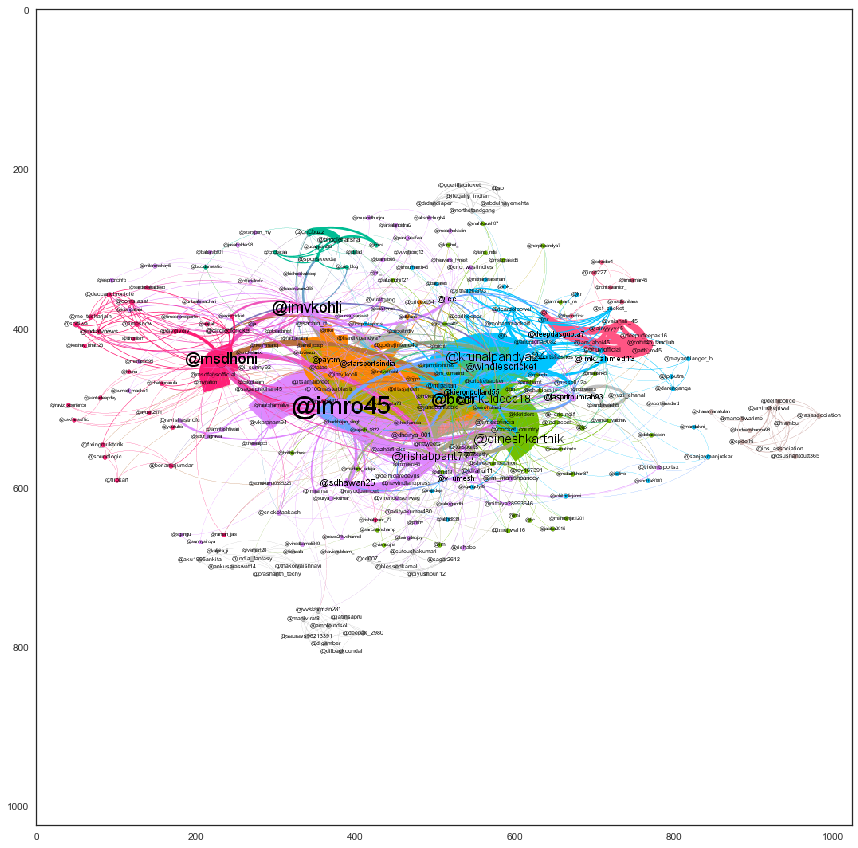

In [65]:
###### Network Analysis from Gephi
plt.figure(figsize=(30,15))
sns.set_style('white')
import matplotlib.image as mpimg
img=mpimg.imread('Players_Network.png')
imgplot = plt.imshow(img)